In [1]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score


In [2]:
import pandas as pd
df = pd.read_csv("/kaggle/input/hc3-dataset/hc3_train_all_features.csv")
df.head()

,text,label,words,sentences,sentence lengths,vocab,line count,word count,avg line length,stop_word_count,...,flesch_reading_ease,flesch_kincaid_grade,lexical_diversity,sentiment_compound,sentiment_pos,sentiment_neg,sentiment_neu,tense_past,tense_present,tense_future
0,"['Basically there are many categories of "" Bes...",0,"['[', ""'Basically"", 'there', 'are', 'many', 'c...","['[\'Basically there are many categories of "" ...","[11, 28, 33, 6, 13, 18, 18, 7, 53, 21, 8, 23, 32]",133,13,279,21.461538,94,...,79.80,6.3,0.476703,0.9980,0.313,0.029,0.658,7,16,5
1,['salt is good for not dying in car crashes an...,0,"['[', ""'salt"", 'is', 'good', 'for', 'not', 'dy...","[""['salt is good for not dying in car crashes ...","[19, 22, 16, 39, 29, 33, 17, 10, 20, 15, 16, 2...",219,22,425,19.318182,170,...,71.44,7.4,0.515294,0.9933,0.157,0.061,0.783,10,45,4
2,"[""The way it works is that old TV stations got...",0,"['[', '``', 'The', 'way', 'it', 'works', 'is',...","['[""The way it works is that old TV stations g...","[23, 88, 55, 14, 12, 14, 52, 22, 31, 23, 7, 25...",231,15,492,32.800000,163,...,59.37,12.1,0.469512,0.9601,0.068,0.018,0.914,14,32,7
3,"[""You ca n't just go around assassinating the ...",0,"['[', '``', 'You', 'ca', ""n't"", 'just', 'go', ...","['[""You ca n\'t just go around assassinating t...","[16, 7, 59, 6, 3, 31, 9, 18, 25, 16, 13]",133,11,211,19.181818,70,...,63.39,8.5,0.630332,-0.2058,0.128,0.132,0.740,5,21,6
4,['Wanting to kill the shit out of Germans driv...,0,"['[', ""'Wanting"", 'to', 'kill', 'the', 'shit',...","[""['Wanting to kill the shit out of Germans dr...","[11, 34, 18, 39, 15, 28, 30, 19, 18, 45, 32]",168,11,294,26.727273,120,...,56.29,11.2,0.571429,0.9615,0.090,0.016,0.895,15,21,2


In [3]:
df.columns

Index(['text', 'label', 'words', 'sentences', 'sentence lengths', 'vocab',
       'line count', 'word count', 'avg line length', 'stop_word_count',
       'active', 'passive', 'NOUN', 'VERB', 'PUNCT', 'DET', 'PRON', 'PROPN',
       'ADJ', 'AUX', 'ADV', 'PART', 'SCONJ', 'NUM', 'X', 'INTJ', 'ADP', 'SYM',
       'SPACE', 'CCONJ', 'proper_noun_count', 'flesch_reading_ease',
       'flesch_kincaid_grade', 'lexical_diversity', 'sentiment_compound',
       'sentiment_pos', 'sentiment_neg', 'sentiment_neu', 'tense_past',
       'tense_present', 'tense_future'],
      dtype='object')

In [4]:
df = df.drop(columns=['words','sentences','sentence lengths'])
df.shape

(48644, 38)

In [6]:
# Device setup
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Step 1: Load Data and Split
X_text = df['text']
y = df['label']
X_numerical = df.drop(columns=['text', 'label'])

# Train-test split
X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_text, X_numerical, y, test_size=0.2, random_state=42
)

# Further split training data into train and validation sets
X_text_train, X_text_val, X_num_train, X_num_val, y_train, y_val = train_test_split(
    X_text_train, X_num_train, y_train, test_size=0.2, random_state=42
)

In [8]:
# Step 2: Text Embeddings using Sentence Transformers
sentence_model = SentenceTransformer('all-mpnet-base-v2')

# Generate embeddings
X_text_train_embeddings = sentence_model.encode(X_text_train.tolist(), convert_to_tensor=True).to(device)
X_text_val_embeddings = sentence_model.encode(X_text_val.tolist(), convert_to_tensor=True).to(device)
X_text_test_embeddings = sentence_model.encode(X_text_test.tolist(), convert_to_tensor=True).to(device)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/973 [00:00<?, ?it/s]

Batches:   0%|          | 0/244 [00:00<?, ?it/s]

Batches:   0%|          | 0/305 [00:00<?, ?it/s]

In [9]:

# Step 3: Scale Numerical Features
scaler = StandardScaler()
X_num_train_scaled = torch.tensor(scaler.fit_transform(X_num_train), dtype=torch.float32).to(device)
X_num_val_scaled = torch.tensor(scaler.transform(X_num_val), dtype=torch.float32).to(device)
X_num_test_scaled = torch.tensor(scaler.transform(X_num_test), dtype=torch.float32).to(device)

# Save the scaler parameters for inference
np.save("scaler_mean.npy", scaler.mean_)
np.save("scaler_scale.npy", scaler.scale_)

In [10]:
# Step 4: Combine Text and Numerical Features
X_train_combined = torch.cat((X_text_train_embeddings, X_num_train_scaled), dim=1)
X_val_combined = torch.cat((X_text_val_embeddings, X_num_val_scaled), dim=1)
X_test_combined = torch.cat((X_text_test_embeddings, X_num_test_scaled), dim=1)

y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
y_val = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

In [11]:
# Step 5: Create a PyTorch Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train_combined, y_train)
val_dataset = CustomDataset(X_val_combined, y_val)
test_dataset = CustomDataset(X_test_combined, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 6: Define the Neural Network
class ClassificationModel(nn.Module):
    def __init__(self, input_size):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)  # No Sigmoid here; use BCEWithLogitsLoss
        return x

In [12]:
# Instantiate the model and move to GPU
input_size = X_train_combined.shape[1]  # 384 (embeddings) + 38 (numerical) = 422
model = ClassificationModel(input_size).to(device)

# Step 7: Define Loss Function, Optimizer, and Scheduler
criterion = nn.BCEWithLogitsLoss()  # Combines Sigmoid + BCE
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [13]:
import matplotlib.pyplot as plt

# Step 8: Training Loop with Validation and Loss Plotting
epochs = 15
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Store average training loss
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    # Store average validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")



Epoch 1/15, Loss: 0.1398, Val Loss: 0.0661
Epoch 2/15, Loss: 0.0858, Val Loss: 0.0530
Epoch 3/15, Loss: 0.0777, Val Loss: 0.0526
Epoch 4/15, Loss: 0.0735, Val Loss: 0.0432
Epoch 5/15, Loss: 0.0643, Val Loss: 0.0416
Epoch 6/15, Loss: 0.0626, Val Loss: 0.0386
Epoch 7/15, Loss: 0.0535, Val Loss: 0.0380
Epoch 8/15, Loss: 0.0541, Val Loss: 0.0398
Epoch 9/15, Loss: 0.0541, Val Loss: 0.0363
Epoch 10/15, Loss: 0.0440, Val Loss: 0.0365
Epoch 11/15, Loss: 0.0429, Val Loss: 0.0350
Epoch 12/15, Loss: 0.0447, Val Loss: 0.0375
Epoch 13/15, Loss: 0.0424, Val Loss: 0.0408
Epoch 14/15, Loss: 0.0373, Val Loss: 0.0341
Epoch 15/15, Loss: 0.0391, Val Loss: 0.0352


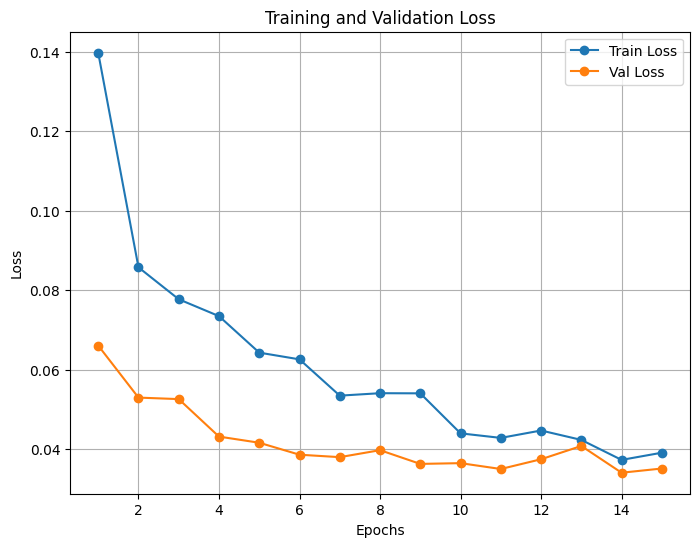

In [14]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, epochs + 1), val_losses, label="Val Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [15]:


# Step 9: Test Evaluation
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        all_labels.extend(y_batch.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
accuracy = (np.array(all_labels) == np.array(all_predictions)).mean()

print(f"Test Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")


Test Accuracy: 98.92%
Precision: 0.99, Recall: 0.99, F1-Score: 0.99
